# A-Scans

In [1]:
import Plots
using Measurements
import Statistics
import CurveFit
using Revise

includet("parse.jl")
includet("peakfinder.jl")
includet("util.jl")

Plots.default(titlefont = (15, "sans-serif"), guidefont = (12, "sans-serif"),
    tickfont = (10, "sans-serif"), legendfont = (10, "sans-serif"))
Plots.pyplot()

Plots.PyPlotBackend()

Initialisierung von Messparametern.

In [2]:
A_1M_kurz = "../../data/DatensatzA/a_scan/1MHz/kurz.dat"

BASEPATH = "../../data/DatensatzA/a_scan/"

FREQS = [1,2,4] # MHz
FREQNAMES = [string(i, "MHz") for i = FREQS]

LENGTHS_UNCERTAINTY = 0.05
LENGTHS = [40,
    79.70,
    120.10]  # mm
UNCERTAIN_LENGTHS = mfl.(LENGTHS, LENGTHS_UNCERTAINTY)
LENGTHNAMES = ["kurz", "mittel", "lang"]
NAMES = [string(t, ".dat") for t = LENGTHNAMES]

# Standard notation [freq x length]
FILENAMES = reshape([string(BASEPATH,fn,'/',n) for fn = FREQNAMES, n = NAMES], (length(FREQS), length(LENGTHS)))

FIGSIZE = (700,400)

(700, 400)

Einlesen der Messdaten. `params`, `datas` enthalten die aus den Dateien gewonnenen Informationen, und sind jeweils NxM-Matrizen, für N Frequenzen und M Stablängen.

In [3]:
# Parse data for all frequencies and shapes.
parsed = reshape([collect(parse_ascan_dat(fn)) for fn in FILENAMES], (length(FREQS), length(LENGTHS)))

params = reshape([p[1] for p in parsed], (length(FREQS), length(LENGTHS)))
datas = reshape([p[2] for p in parsed], (length(FREQS), length(LENGTHS)))
titles = map(parameters_to_title, params)


3×3 Matrix{String}:
 "T1 - R2, o/g = 5 dB/5 dB"   …  "T1 - R2, o/g = 5 dB/5 dB"
 "T1 - R2, o/g = 5 dB/10 dB"     "T1 - R2, o/g = 10 dB/5 dB"
 "T1 - R2, o/g = 5 dB/15 dB"     "T1 - R2, o/g = 5 dB/15 dB"

## Rohdaten
Wir testen, ob die Daten korrekt eingelesen wurden.

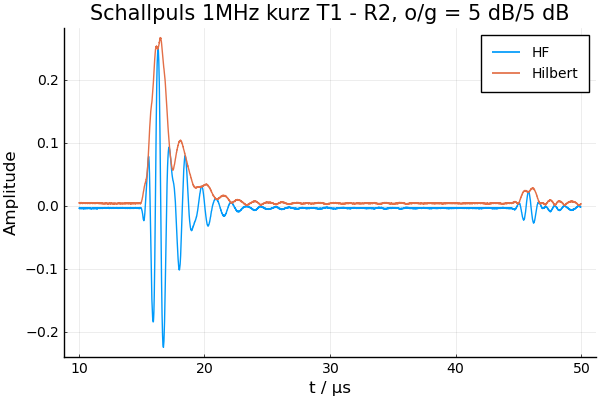

In [4]:
i, j = 1,1
freq, meas = FREQNAMES[i], LENGTHNAMES[j]
dat = datas[i,j]
Plots.plot(dat[:,1], dat[:,2], label="HF",
    title=string("Schallpuls ", freq, ' ', meas, ' ', titles[i,j]),
    xlabel="t / μs", ylabel="Amplitude",
    leg=true, figsize=FIGSIZE)
Plots.plot!(dat[:,1], envelope_of(dat[:,2]), label="Hilbert")

und generieren alle Plots als PDF-Dateien.

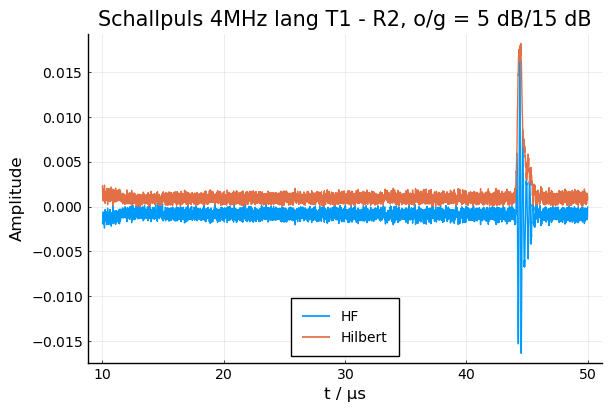

In [5]:
# Generate raw plots for all A-Scan measurements together with Hilbert transforms.
for i = 1:3
    for j = 1:3
        freq, meas = FREQNAMES[i], LENGTHNAMES[j]
        dat = datas[i,j]
        Plots.plot(dat[:,1], dat[:,2], label="HF",
            title=string("Schallpuls ", freq, ' ', meas, ' ', titles[i,j]),
            xlabel="t / μs", ylabel="Amplitude",
            legend=:bottom)
        Plots.savefig(Plots.plot!(dat[:,1], envelope_of(dat[:,2]), label="Hilbert"),
            "../../img/ascan/raw_$(freq)_$meas.pdf")
    end
end

## Laufzeitmessung

Wir ermitteln die maßgebliche Laufzeit durch Fitten einer Normalverteilung an den höchsten Peak der Hilbert-Hüllkurve.

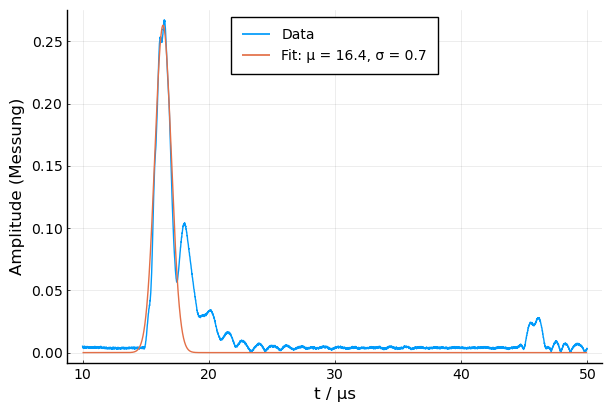

In [6]:
# Check fits of maxima to peaks graphically

data = datas[1,1]
xs = data[:,1]
ys = envelope_of(data[:,2])
p = check_fit_plot(xs, ys; xlabel="t / μs", ylabel="Amplitude (Messung)",
    legend=:top, figsize=FIGSIZE)
Plots.savefig(p, "fitplot.pdf")

und ermitteln die Laufzeit für alle Signale. Im zweiten Abschnitt ermitteln wir noch die Laufzeit der Reflexion für die kurzen Stäbe.

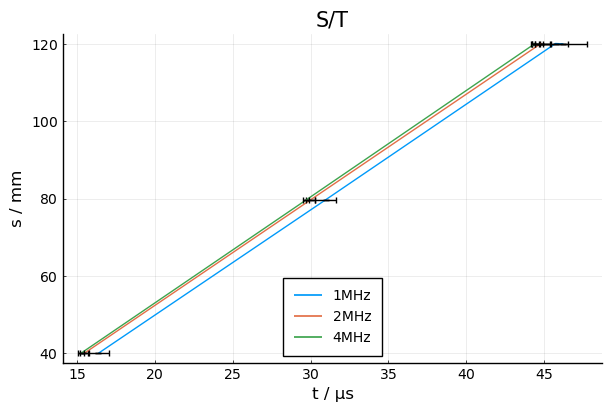

3×4 Matrix{Measurement{Float64}}:
 16.38±0.65  30.97±0.69  45.72±0.79    46.2±1.5
 15.48±0.28  30.01±0.31  44.79±0.57   44.82±0.61
 15.26±0.17  29.73±0.2   44.41±0.25  44.405±0.0014

In [28]:
# Calculate peak locations for all measurements so we end up
# with time difference for lengths, for each frequency.
# Uncertainties of t are the Peak's σ.

t_vals = zeros(Measurement{Float64}, size(datas))
s_vals = zeros(Float64, size(datas))

for freqix = range(1, size(datas)[1], step=1)
    for lenix = range(1, size(datas)[2], step=1)
        # Determine t from peak.
        data = datas[freqix, lenix]
        s_vals[freqix, lenix] = s = LENGTHS[lenix]
        (μ, σ, scale), _stds = crop_and_fit_peak(data[:, 1], envelope_of(data[:, 2]))
        t_vals[freqix, lenix] = measurement(μ, σ)
        
        # We can also use the location of the rising edge
        rising_edge_loc = find_rise_threshold(xs, envelope_of(data[:,2]))
        #t_vals[freqix, lenix] = measurement(rising_edge_loc, 2)
    end
end

# Search for the secondary (twice-reflected) peaks.

secondpeak_t_vals = zeros(M64, size(FREQS))
secondpeak_s_vals = ones(M64, size(secondpeak_t_vals)) .* 3*LENGTHS[1]

for freqix = range(1, size(FREQS)[1], step=1)
    # Find second peak.
    data = datas[freqix, 1]
    npts = size(data)[1]
    cropped = data[div(npts, 2):end, :]

    (μ, σ, scale), stds = crop_and_fit_peak(cropped[:,1], envelope_of(cropped[:, 2]))
    secondpeak_t_vals[freqix] = measurement(μ, (σ))
end

# Extend main peak measurements with twice-reflected peak measurements.

extended_t_vals = reshape([t_vals...; secondpeak_t_vals], (size(t_vals)[1], size(t_vals)[2]+1))
extended_s_vals = reshape([s_vals...; secondpeak_s_vals], (size(s_vals)[1], size(s_vals)[2]+1))

p = Plots.plot(transpose(extended_t_vals), transpose(extended_s_vals),
    xlabel="t / μs", ylabel="s / mm", title="S/T",
    figsize=FIGSIZE,
    legend=:bottom,
    label=permutedims(FREQNAMES))
Plots.savefig(p, "linreg.pdf")

# Uncomment this to utilize the reflection measurement
#t_vals[:, 1] = secondpeak_t_vals
round.((extended_t_vals), digits=4)

Wir betrachten kurz die Dispersion; die Streuung ist aber sehr groß.

Lineare Regressionen für die Laufzeitmessungen bei jeder Frequenz.

1MHz 2702.984411295782±103.16576143360398; b = -4.185 ± 3.114
  Shift, +: 1MHz 2702.984411295782±103.16576143360395; b = -4.135 ± 3.114
  Shift, -: 1MHz 2702.984411295776±103.16576143360355; b = -4.235 ± 3.114
2MHz 2729.6011171305±49.0817580778828; b = -2.238 ± 1.382
  Shift, +: 2MHz 2729.601117130503±49.08175807788289; b = -2.188 ± 1.382
  Shift, -: 2MHz 2729.6011171305±49.0817580778828; b = -2.288 ± 1.382


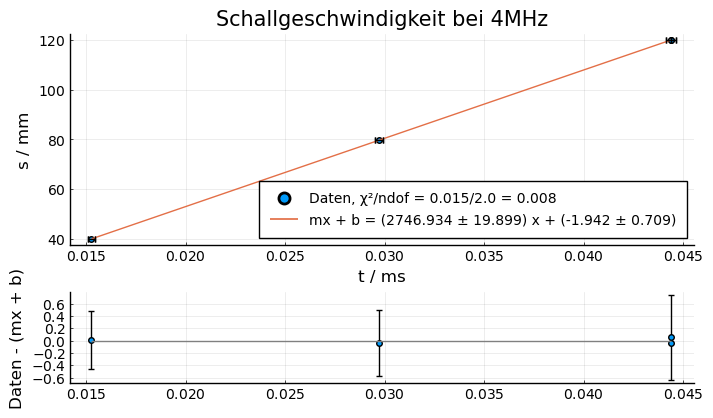

4MHz 2746.9340545956975±19.89903170544824; b = -1.942 ± 0.709
  Shift, +: 4MHz 2746.9340545957007±19.89903170544828; b = -1.892 ± 0.709
  Shift, -: 4MHz 2746.9340545956975±19.89903170544824; b = -1.992 ± 0.709


In [44]:
SPEEDS_OF_SOUND_BY_FREQ = zeros(M64, length(FREQS))
bs = []

# Calculate linear regressions and save plots.
for (freqix, freqname) in enumerate(FREQNAMES)
    t, s = extended_t_vals[freqix,:]/1e3, extended_s_vals[freqix,:]
    freq = FREQNAMES[freqix]
    lr = linreg(t, s, allow_offset=true)
    print(freqname, ' ', nv(lr.m), '±', sd(lr.m),
        "; b = $(round(nv(lr.b), digits=3)) ± $(round(sd(lr.b), digits=3))", '\n')
    
    lr_h, lr_l = linreg(t, s .+ LENGTHS_UNCERTAINTY), linreg(t, s .- LENGTHS_UNCERTAINTY)
    print("  Shift, +: ", freqname, ' ', nv(lr_h.m), '±', sd(lr_h.m),
        "; b = $(round(nv(lr_h.b), digits=3)) ± $(round(sd(lr_h.b), digits=3))", '\n')
    print("  Shift, -: ", freqname, ' ', nv(lr_l.m), '±', sd(lr_l.m),
        "; b = $(round(nv(lr_l.b), digits=3)) ± $(round(sd(lr_l.b), digits=3))", '\n')
    
    p = linreg_residual_plot(
        t, s, figsize=FIGSIZE, title="Schallgeschwindigkeit bei $freq",
        legend=:bottomright, xlabel="t / ms", ylabel="s / mm")
    Plots.savefig(p, "../../img/ascan/linreg_$freq.pdf")
    
    SPEEDS_OF_SOUND_BY_FREQ[freqix] = lr.m
    push!(bs, lr.b)
end


In [45]:
weightedmean(SPEEDS_OF_SOUND_BY_FREQ), weightedmean(bs)

(2743.0 ± 18.0, -2.09 ± 0.62)

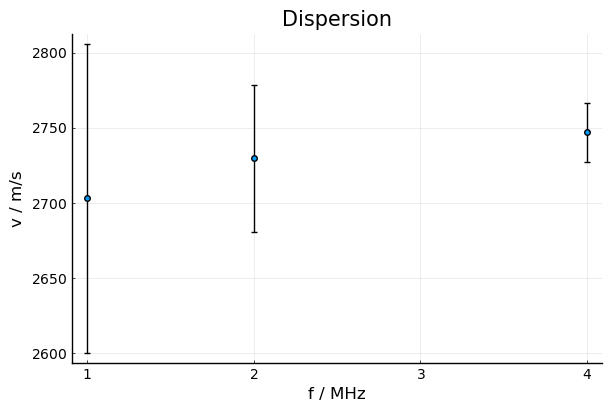

1×4 Matrix{String}:
 "kurz"  "mittel"  "lang"  "kurz (3x)"

In [30]:
# Plot dispersion (v as a function of f)

dispersion_data = SPEEDS_OF_SOUND_BY_FREQ
dispersion_abscissa = FREQS
dispersion_labels = permutedims([LENGTHNAMES; "kurz (3x)"])

p = Plots.plot(dispersion_abscissa, dispersion_data, legend=nothing,
    marker=:dot, ylabel="v / m/s", xlabel="f / MHz",
    title="Dispersion", figsize=FIGSIZE, typ=:scatter)
Plots.savefig(p, "../../img/ascan/dispersion.pdf")
dispersion_labels

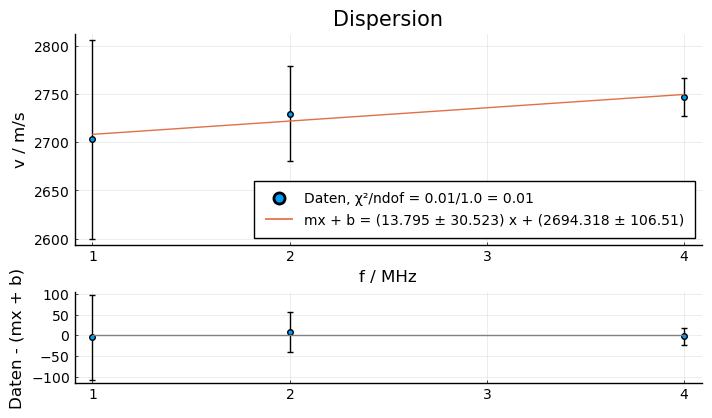

In [31]:
Plots.savefig(linreg_residual_plot(dispersion_abscissa, dispersion_data,ylabel="v / m/s", xlabel="f / MHz",
    title="Dispersion", figsize=FIGSIZE, legend=:bottomright),
    "../../img/ascan/dispersion_linreg.pdf")

Nun werfen wir alle Laufzeiten zusammen und stecken sie in eine lineare Regression.

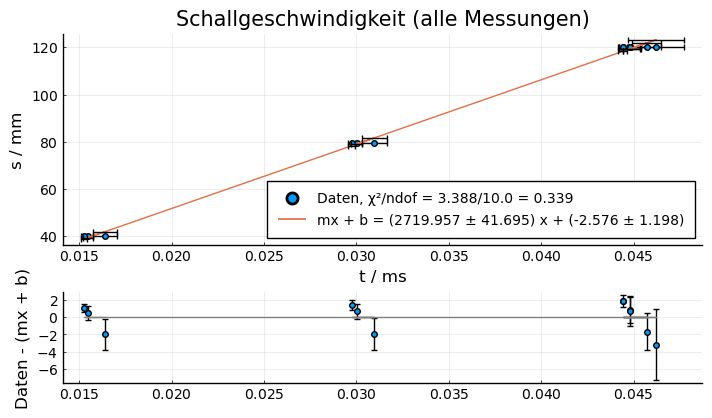

2719.9573282781303±41.694806500943045; b = -2.576 ± 1.198


In [41]:
# Calculate speed of sound using all frequency data instead of just one.

t, s = (reshape(extended_t_vals, length(extended_t_vals))/1e3,
        reshape(extended_s_vals, length(extended_s_vals)))
lr = linreg(t, s)
print(nv(lr.m), '±', sd(lr.m),
        "; b = $(round(nv(lr.b), digits=3)) ± $(round(sd(lr.b), digits=3))", '\n')

p = linreg_residual_plot(
    t, s, figsize=FIGSIZE, title="Schallgeschwindigkeit (alle Messungen)",
    legend=:bottomright, xlabel="t / ms", ylabel="s / mm")
Plots.savefig(p, "../../img/ascan/linreg_all.pdf")

## Dämpfung

Im folgenden berechnen wir die Dämpfung des Materials.

In [33]:
# Calculate attenuation

MAX_ABS_AMPLITUDE = zeros((size(datas)[1], size(datas)[2]))
SECOND_PEAK_MAX_ABS_AMPL = zeros(size(FREQS))

for freqix = range(1, size(datas)[1], step=1)
    for lenix = range(1, size(datas)[2], step=1)
        MAX_ABS_AMPLITUDE[freqix, lenix] = maximum(
            abs.(datas[freqix, lenix][:, 2]))
    end
    
    # Only check second half for reflected pulse.
    #MAX_ABS_AMPLITUDE[freqix, size(datas)[2]+1] = maximum(abs.(datas[freqix, 1][div(size(datas[freqix, 1])[1],2):end,2]))
end

function integrate_envelope(xs, ys)
    delta = mean(xs[2:end]-xs[1:end-1])
    return sum(delta.*envelope_of(ys))
end

RELATIVE_MAX_AMPLITUDE = relative_amplitude = MAX_ABS_AMPLITUDE./mapslices(maximum, MAX_ABS_AMPLITUDE, dims=2)


3×3 Matrix{Float64}:
 1.0  0.5072    0.24028
 1.0  0.305544  0.113859
 1.0  0.185481  0.0298889

Plot und Exponential-Fit für die Dämpfungsmessungen.

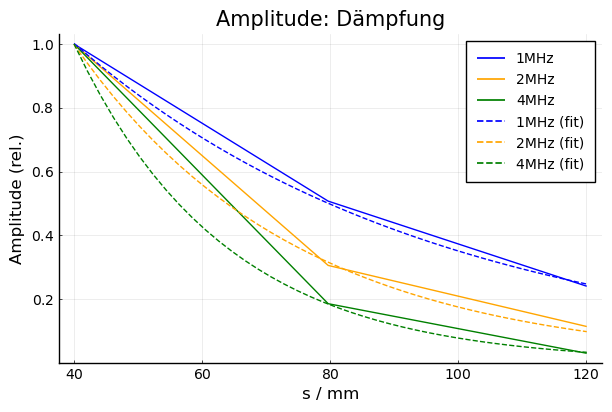

Measurement{Float64}[-0.01748 ± 0.00039, -0.029 ± 0.0014, -0.04259 ± 0.00043]

3×3 Matrix{Float64}:
  40.0   40.0   40.0
  79.7   79.7   79.7
 120.1  120.1  120.1

In [34]:
# Plot attenuation
# TODO: What is the uncertainty on this?
# Plot for each frequency as function of length.

# plotampl is len x freq

plotampl = permutedims(RELATIVE_MAX_AMPLITUDE)
plotlens = broadcast(*, LENGTHS, permutedims(ones(size(LENGTHS))))


# Fit an exponential function to the measured data
#exp_coeffs = [CurveFit.exp_fit(plotlens[:,i], plotampl[:,i])
#    for i = 1:size(plotampl)[2]]

function exponential_model(x::Vector{Float64}, ps)
    return ps[1] * exp.(ps[2].*x)
end

# Using LsqFit, we can also obtain fit errors.
exp_fits = [LsqFit.curve_fit(
        exponential_model, plotlens[:,i], plotampl[:,i], [1, 0.1])
    for i = 1:size(plotampl)[2]]
exp_coeffs = map(f -> f.param, exp_fits)
exp_stds = map(f -> [sqrt(LsqFit.estimate_covar(f)[i,i]) for i = 1:2], exp_fits)
exp_unc_coeffs = map(vs -> mfl(vs[1][2], vs[2][2]), zip(exp_coeffs, exp_stds))
print(exp_unc_coeffs)

fitxs = repeat(LinRange(minimum(plotlens), maximum(plotlens), 40), 1, size(plotampl)[2])
fitys = map(p -> p[1].*exp.(p[2]*(fitxs[:,1])), exp_coeffs)

p = Plots.plot(plotlens, plotampl, label=permutedims(FREQNAMES),
    figsize=FIGSIZE, color=[:blue :orange :green],
    xlabel="s / mm", ylabel="Amplitude (rel.)", title="Amplitude: Dämpfung")
Plots.plot!(fitxs, fitys,
    label=permutedims(map(n -> "$n (fit)", FREQNAMES)),
    color=[:blue :orange :green], style=:dash)
Plots.savefig(p, "../../img/ascan/attenuation_by_freq.pdf")

exp_coeffs
plotlens

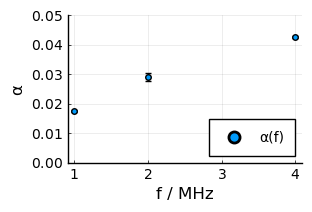

In [35]:
p = Plots.scatter([1,2,4], -exp_unc_coeffs, label="α(f)", legend=:bottomright,
    xlabel="f / MHz", ylabel="α", ylim=(0,0.05), size=(300,200))
Plots.savefig(p, "../../img/ascan/daempfung_frequenz.pdf")

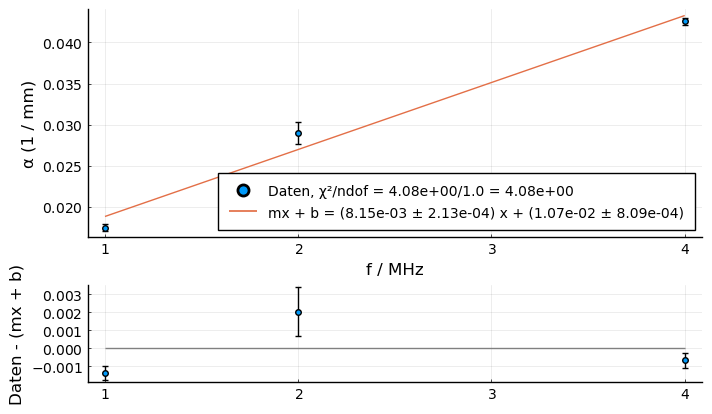

In [36]:
Plots.savefig(linreg_residual_plot([1,2,4], -exp_unc_coeffs, legend=:bottomright,
    xlabel="f / MHz", ylabel="α (1 / mm)", expo=true, figsize=(700,400)), "../../img/ascan/daempfung_frequenz_linreg.pdf")

In [37]:
linreg([1,2,4], -exp_unc_coeffs)

LinReg(0.00815 ± 0.00021, 0.01069 ± 0.00081, 4.077552935226813, 3.0, 1.0)

In [38]:
# Figure out attenuation factor for each frequency
# For this, we take the amplitude difference between measurements of two lengths (mid/short, long/mid, long/short)
# and calculate the attenuation from that.

MEASURE = MAX_ABS_AMPLITUDE

# Combinations of lengths that we calculate the attenuation from.
lenix_combos = [(i, j) for i = 2:length(LENGTHS), j = 1:(length(LENGTHS)-1) if i != j]
attenuations = zeros(M64, (size(MEASURE)[1], size(lenix_combos)[1]))

for freqix = 1:size(attenuations)[1]
    for (i, (lenix_h, lenix_l)) = enumerate(lenix_combos)
        A0 = MEASURE[freqix, lenix_l]
        A = MEASURE[freqix, lenix_h]
        dist = UNCERTAIN_LENGTHS[lenix_h]-UNCERTAIN_LENGTHS[lenix_l]
        att = log(A0/A)/dist
        print("$(FREQNAMES[freqix]) $(LENGTHNAMES[lenix_h]) - $(LENGTHNAMES[lenix_l]): A0 = $A0, A = $A, dist = $dist, α = $att, \n")
        attenuations[freqix, i] = att
    end
end

attenuations

1MHz mittel - kurz: A0 = 0.25, A = 0.1268, dist = 39.7 ± 0.071, α = 0.017099 ± 3.0e-5, 
1MHz lang - kurz: A0 = 0.25, A = 0.06007, dist = 80.1 ± 0.071, α = 0.017802 ± 1.6e-5, 
1MHz lang - mittel: A0 = 0.1268, A = 0.06007, dist = 40.4 ± 0.071, α = 0.018493 ± 3.2e-5, 
2MHz mittel - kurz: A0 = 0.469, A = 0.1433, dist = 39.7 ± 0.071, α = 0.029866 ± 5.3e-5, 
2MHz lang - kurz: A0 = 0.469, A = 0.0534, dist = 80.1 ± 0.071, α = 0.027126 ± 2.4e-5, 
2MHz lang - mittel: A0 = 0.1433, A = 0.0534, dist = 40.4 ± 0.071, α = 0.024434 ± 4.3e-5, 
4MHz mittel - kurz: A0 = 0.5758, A = 0.1068, dist = 39.7 ± 0.071, α = 0.042438 ± 7.6e-5, 
4MHz lang - kurz: A0 = 0.5758, A = 0.01721, dist = 80.1 ± 0.071, α = 0.043824 ± 3.9e-5, 
4MHz lang - mittel: A0 = 0.1068, A = 0.01721, dist = 40.4 ± 0.071, α = 0.045185 ± 7.9e-5, 


3×3 Matrix{Measurement{Float64}}:
 0.017099±3.0e-5  0.017802±1.6e-5  0.018493±3.2e-5
 0.029866±5.3e-5  0.027126±2.4e-5  0.024434±4.3e-5
 0.042438±7.6e-5  0.043824±3.9e-5  0.045185±7.9e-5

Gewichtetes Mittel für alle Frequenzen berechnen.

In [39]:
weighted_att = mapslices(weightedmean, attenuations, dims=2)

for (i,wm) = enumerate(weighted_att)
    var = Statistics.std(attenuations[i,:])
    print("Weighted attenuation mean at $(FREQNAMES[i]): α = $wm 1/mm, Std α = $var \n")
end

Weighted attenuation mean at 1MHz: α = 0.017786 ± 1.3e-5 1/mm, Std α = 0.000697 ± 2.7e-5 
Weighted attenuation mean at 2MHz: α = 0.026935 ± 1.9e-5 1/mm, Std α = 0.002716 ± 4.2e-5 
Weighted attenuation mean at 4MHz: α = 0.043799 ± 3.2e-5 1/mm, Std α = 0.001373 ± 6.7e-5 
